# Cavity Project

Writen by: Oscar Reula (oreula@gmail.com)

This code is writen in Fenics/Python, it is used to compute the natural frequencies of a resonant cavity. We solve 2 dimensional problems. This restriction is mainly due to have a code that can run in home computers in very short time. 

We first call all the libraries needed. You can find a very good tutorial for Fenics at: http://launchpad.net/fenics-book/trunk/final/+download/fenics-book-2011-10-27-final.pdf

First we test that all the libraries are in place.

In [1]:
from dolfin import *

# Test for PETSc and SLEPc
if not has_linear_algebra_backend("PETSc"):
    print("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

if not has_slepc():
    print("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

In [3]:
%matplotlib inline

"""
FEniCS program to compute the capacity matrix of several conductors enclosed in a box
"""

#from __future__ import print_function
from fenics import *
from mshr import *
from math import pi
import numpy as np
import matplotlib.pyplot as mpl

We first create some objects and include them into first, which is a square, to create a **domain**. After that we generate a mesh for that domain. The number in it is the number of triangulations. Could be from 32 to 254, say, for a short calculation. To test the code is running correctly run first a single unit square and check that the eigenvalues and eigenvectors coincide with the exact ones. Remember in this case $\lambda = \pi \sqrt{2}$

In [4]:
# Create mesh and define function space

test = True
#test = False
case_1 = False
#case_1 = True

if case_1:
    side_x = 1.
    side_y = 1.
    square =  Rectangle(Point(0, 0), Point(side_x,side_y))
 

    cy_center_x = 0.5
    cy_center_y = 0.5
    cy_radious = 0.15

    square =  Rectangle(Point(0, 0), Point(side_x,side_y))
    cylinder =  Circle(Point(cy_center_x, cy_center_y), cy_radious)

    domain = square - cylinder

    mesh =  generate_mesh(domain, 64)
    
if test:
    
    domain = Rectangle(Point(0, 0), Point(1.0,1.0))
    mesh =  generate_mesh(domain, 64)
    #mesh = UnitSquareMesh(32, 32)


We generate the function space, this are polynomials of degree 1. The first is for the potential, a scalar, the second for the electric field.

In [5]:
#V = FunctionSpace(mesh, 'Lagrange', 1)
V = FunctionSpace(mesh, 'P', 1)
#V = FunctionSpace(mesh, 'CG', 2)
#W = VectorFunctionSpace(mesh, 'P', 1)

Next we define the boundaries, they are needed to impose the boundary conditions and then to compute the charges. 

In [10]:
# Define boundary condition


tol = 1E-14

if case_1:
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    class outer_0(SubDomain):
        def inside(self, x, on_boundary):
            return  near(x[0], 0, tol) or near(x[0],side_x, tol) \
                or near(x[1],0, tol) or near(x[1],side_y, tol)
    outer0 = outer_0()
    outer0.mark(boundary_markers, 0)
                                

    class cyl_1(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and x[0] > (cy_center_x - cy_radious - tol) and x[0] < (cy_center_x + cy_radious + tol) and x[1] > (cy_center_y - cy_radious - tol) and x[1] < (cy_center_y + cy_radious + tol)
    cyl1 = cyl_1()
    cyl1.mark(boundary_markers,1)



    # the boundary surface elements 
    ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)
             

    u_outer = Expression('0', degree=2)
    u_cyl = Expression('0', degree=2)


    bc_out = DirichletBC(V, u_outer, outer0)
    bc_cyl = DirichletBC(V, u_cyl, cyl1)


    bcs = [bc_out, bc_cyl]
    
if test: 
    
#    boundary_markers = FacetFunction('size_t', mesh)
    boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    class outer_0(SubDomain):
        def inside(self, x, on_boundary):
            return  near(x[0], 0, tol) or near(x[0],1., tol) \
                or near(x[1],0, tol) or near(x[1],1., tol)
    outer0 = outer_0()
    outer0.mark(boundary_markers, 0)
    u_outer = Expression('0', degree=2)
    
    u0 = Constant(0.0)
    bcs = DirichletBC(V, u_outer, outer0)



Next we define the problem (in the weak sense) we want to solve. First the function spaces, then the sources according to the problem and then the matrices and sources to solve a problem of the type $A x = b$. Recall the weak problem is: 
\begin{equation}
\int_{\Omega} \nabla u \cdot \nabla v \; dV = \int_{\Omega} f v \; dV \;\;\;\; \forall \;v \in \; V
\end{equation}

In [11]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

f = Constant(-0.0)
    
a = dot(grad(u), grad(v))*dx
m = u*v*dx
l = f*v*dx

We call then a solver with the correct boundary conditions. (There are many solvers, and paramaters can be used. Here we do the simplest.) 

In [12]:
try3 = True
try1 = False
try2 = False

if try1:
# Assemble stiffness form
    A, M, b = PETScMatrix(), PETScMatrix(), PETScVector()
    assemble_system(a, l, bcs, A_tensor=A, b_tensor=b)
    assemble_system(m, l, bcs, A_tensor=M, b_tensor=b)
    [bc.zero(M) for bc in bcs]
#A = PETScMatrix()
#assemble(a, tensor=A)

if try2:
    A, _ = assemble_system(a, l, bcs)
    M, _ = assemble_system(m, l, bcs)
  # set the diagonal elements of M corresponding to boundary nodes to zero to
  # remove spurious eigenvalues.
    bc.zero(M)
  # downcast to PETSc matrices
    A = down_cast(A)
    M = down_cast(M)

    
if try3:
    A = PETScMatrix()
    M = PETScMatrix()
    
    assemble(a,tensor=A)
    #[bc.zero(A) for bc in bcs]
    bcs.zero(A)
    #bcs.zero_columns(A,Function(V).vector(),1.0e10)

    assemble(m,tensor=M)
    bcs.apply(M)

    
    
    
    
    
    
    
    
    
number_of_eigenvalues_to_compute = 20

# Create eigensolver
eigensolver = SLEPcEigenSolver(A,M)
eigensolver.parameters['spectrum'] = 'smallest real'
#eigensolver.parameters['tolerance'] = 1.e-14
eigensolver.parameters['problem_type'] = 'gen_hermitian'
#eigensolver.parameters['maximum_iterations'] = 200
#eigensolver.parameters['spectral_transform'] = 'shift-and-invert'

# Compute all eigenvalues of A x = \lambda x
print("Computing eigenvalues. This can take a minute.")
eigensolver.solve(number_of_eigenvalues_to_compute)
#eigensolver.solve(5)




Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Computing eigenvalues. This can take a minute.


In [13]:
# Extract the smallest eigenpairs

for d in range(0,number_of_eigenvalues_to_compute):
    r, c, rx, cx = eigensolver.get_eigenpair(d)

    print("eigenvalue " + repr(d) + " = "  + repr(r))

# Initialize function and assign eigenvector
u = Function(V)
u.vector()[:] = rx

print("exact values are: ", pi*pi*2. , pi*pi*5., pi*pi*8. )


eigenvalue 0 = 19.744794498132315
eigenvalue 1 = 49.38216339610047
eigenvalue 2 = 49.38254688192799
eigenvalue 3 = 79.04444896409736
eigenvalue 4 = 98.8326302230307
eigenvalue 5 = 98.8345224131517
eigenvalue 6 = 128.53589862016887
eigenvalue 7 = 128.53921814700175
eigenvalue 8 = 168.18192202852285
eigenvalue 9 = 168.18580803427918
eigenvalue 10 = 178.10233839890722
eigenvalue 11 = 197.93660749892283
eigenvalue 12 = 197.9538899781076
eigenvalue 13 = 247.60413198653845
eigenvalue 14 = 247.60984574769498
eigenvalue 15 = 257.54589223944697
eigenvalue 16 = 257.5501539181169
eigenvalue 17 = 287.3815062745208
eigenvalue 18 = 287.387830723535
eigenvalue 19 = 317.23825741336276
exact values are:  19.739208802178716 49.34802200544679 78.95683520871486


In test mode we get the first non-trivial eigenvalue and compare the nuerical solution with the exact one.

In [14]:
# have to check above which one is the first non-trivial eigenvalue.
if test:

    r, c, rx, cx = eigensolver.get_eigenpair(4)

    u.vector()[:] = rx


# Re-scale solution to have L2 norm unity.
    u_n = Function(V)
    u_0 = Expression('0.0', degree=2) #this should be just a norm TODO

    L2_inv = 1./errornorm(u_0, u, 'L2')
    print(L2_inv)

    u_n = project(L2_inv*u,V)
    norm_L2 = errornorm(u_0, u_n, 'L2')
    print(norm_L2)

# we compute the exact solution here (you can try others)
    u_D = Expression('-2.*sin(pi*x[0])*sin(pi*x[1])', degree=2)
# Compute error in L2 norm
    error_L2 = errornorm(u_D, u_n, 'L2')

# Compute maximum error at vertices
    vertex_values_u_D = u_D.compute_vertex_values(mesh)
    vertex_values_u = u_n.compute_vertex_values(mesh)
    error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
    u_max = np.max(np.abs(vertex_values_u))
# Print errors
    print('max =', u_max)
    print('error_L2  =', error_L2)
    print('error_max =', error_max/u_max)
    
# if you get a large value try changing the sign of u_D    

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.9999999999999998
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
1.0000000000000002
max = 2.227986743384619
error_L2  = 1.4142129332357858
error_max = 1.5284968163711095


We then plot the solution on screen and save to files the solution in a special format to visualize with Paraview or VisIt.

Calling FFC just-in-time (JIT) compiler, this may take some time.


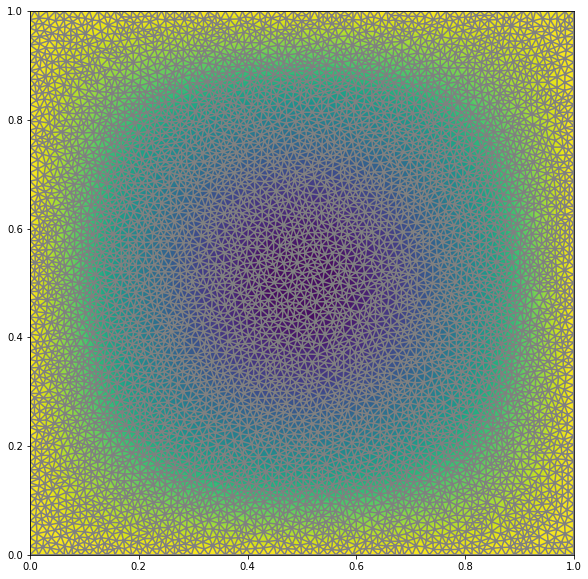

In [15]:
# for plotting we get the eigenfunction and normalize it for better plotting and comparing.

r, c, rx, cx = eigensolver.get_eigenpair(0)

u = Function(V)
u.vector()[:] = rx


# Re-scale solution to have L2 norm unity.
u_n = Function(V)
u_0 = Expression('0.0', degree=2) #this should be just a norm TODO
L2_inv = 1./errornorm(u_0, u, 'L2')
u_n = project(L2_inv*u,V)
    
# Plot eigenfunction and mesh
mpl.figure(figsize=(10,10))
plot(u_n)
plot(mesh)

# Save solution to file in VTK format

vtkfile_phi = File('Cavity/potential_0.pvd')
vtkfile_e = File('Cavity/field_0.pvd')

    
vtkfile_phi << u_n

We can also compute the electric field and save it in a file.

In [16]:
# Compute de electric field
#W = VectorFunctionSpace(mesh, 'P', 1)
W = VectorFunctionSpace(mesh, 'CG', 2)
grad_u = project(-grad(u),W)


vtkfile_e << grad_u

Calling FFC just-in-time (JIT) compiler, this may take some time.


Recall that the charge is defined as: 
\begin{equation}
Q_i = \int_{\partial \Omega_i} \sigma dS =  4\pi\int_{\partial \Omega_i} E \cdot \; dS
\end{equation}
And the **capacity matrix** by the relation: 

\begin{equation}
Q_i = C_{ij}V^j
\end{equation}

In [17]:
# Compute the charge integral

n = FacetNormal(mesh)
square_flux = -dot(grad(u),n)*ds(1)
Q_square = assemble(square_flux)

cyl_flux = -dot(grad(u),n)*ds(2)
Q_cyl = assemble(cyl_flux)

print('Charge_square = {0:.4f}, Charge_cyl = {1:.4f} ' .format(Q_square, Q_cyl))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Charge_square = 0.0000, Charge_cyl = 0.0000 
